# Feature Engineering in Keras.

Let's start off with the Python imports that we need.

In [1]:
import os, json, math, shutil
import datetime
import numpy as np
import tensorflow as tf
print(tf.version.VERSION)

2.0.0-dev20190820


In [2]:
# Note that this cell is special. It's got a tag (you can view tags by clicking on the wrench icon on the left menu in Jupyter)
# These are parameters that we will configure so that we can schedule this notebook
DATADIR = '../data'
OUTDIR = './trained_model'
NBUCKETS = 10  # for feature crossing
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # remember the training dataset repeats, so this will wrap around
NUM_EVALS = 5  # evaluate this many times
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but no so much that it slows down

## Locating the CSV files

We will start with the CSV files that we wrote out in the [first notebook](../01_explore/taxifare.iypnb) of this sequence. Just so you don't have to run the notebook, we saved a copy in ../data

In [3]:
if DATADIR[:5] == 'gs://':
    !gsutil ls $DATADIR/*.csv
else:
    !ls -l $DATADIR/*.csv

-rw-r--r-- 1 jupyter jupyter 123590 Aug  6 00:27 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579055 Aug  6 00:27 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 123114 Aug  6 00:27 ../data/taxi-valid.csv


## Use tf.data to read the CSV files

We wrote these cells in the [third notebook](../03_tfdata/input_pipeline.ipynb) of this sequence.

In [4]:
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

In [5]:
def features_and_labels(row_data):
    for unwanted_col in ['key']:  # keep the pickup_datetime!
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    pattern = '{}/{}'.format(DATADIR, pattern)
    dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
               .map(features_and_labels) # features, label
               )
    if mode == tf.estimator.ModeKeys.TRAIN:
        print("Repeating training dataset indefinitely")
        dataset = dataset.shuffle(1000).repeat()
    dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
    return dataset

In [6]:
def parse_datetime(s):
    if type(s) is not str:
        s = s.numpy().decode('utf-8') # if it is a Tensor
    return datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S %Z")

In [7]:
for s in ['2012-07-05 14:18:00 UTC']:
    print(s)
    for ts in [parse_datetime(s), parse_datetime(tf.constant(s))]: # as string, as tensor
        print(ts.weekday())
        DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
        print(DAYS[ts.weekday()])

2012-07-05 14:18:00 UTC
3
Wed
3
Wed


In [8]:
## Add transformations
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)

DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
def get_dayofweek(s):
    ts = parse_datetime(s)
    return DAYS[ts.weekday()]

@tf.function
def dayofweek(ts_in):
    return tf.map_fn(
        lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
        ts_in
    )

@tf.function
def fare_thresh(x):
    return 60 * tf.keras.activations.relu(x)

def transform(inputs, NUMERIC_COLS, STRING_COLS):
    print("BEFORE TRANSFORMATION")
    print("INPUTS:", inputs.keys())
    
    # Pass-through columns
    transformed = inputs.copy()
    del transformed['pickup_datetime']
    
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
           for colname in NUMERIC_COLS
    }
    
    # scale the lat, lon values to be in 0, 1
    if True:
        for lon_col in ['pickup_longitude', 'dropoff_longitude']:  # in range -70 to -78
            transformed[lon_col] = tf.keras.layers.Lambda(
                lambda x: (x+78)/8.0, 
                name='scale_{}'.format(lon_col)
            )(inputs[lon_col])
        for lat_col in ['pickup_latitude', 'dropoff_latitude']: # in range 37 to 45
            transformed[lat_col] = tf.keras.layers.Lambda(
                lambda x: (x-37)/8.0, 
                name='scale_{}'.format(lat_col)
            )(inputs[lat_col])

    # add Euclidean distance. Doesn't have to be accurate calculation because NN will calibrate it
    if True:
        transformed['euclidean'] = tf.keras.layers.Lambda(euclidean, name='euclidean')([
            inputs['pickup_longitude'],
            inputs['pickup_latitude'],
            inputs['dropoff_longitude'],
            inputs['dropoff_latitude']
        ])
        feature_columns['euclidean'] = tf.feature_column.numeric_column('euclidean')
    
    # hour of day from timestamp of form '2010-02-08 09:17:00+00:00'
    if True:
        transformed['hourofday'] = tf.keras.layers.Lambda(
            lambda x: tf.strings.to_number(tf.strings.substr(x, 11, 2), out_type=tf.dtypes.int32),
            name='hourofday'
        )(inputs['pickup_datetime'])
        feature_columns['hourofday'] = tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_identity('hourofday', num_buckets=24))

    if False:
        # https://buganizer.corp.google.com/issues/137795281
        # day of week is hard because there is no TensorFlow function for date handling
        transformed['dayofweek'] = tf.keras.layers.Lambda(
            lambda x: dayofweek(x),
            name='dayofweek_pyfun'
        )(inputs['pickup_datetime'])
        transformed['dayofweek'] = tf.keras.layers.Reshape((), name='dayofweek')(transformed['dayofweek'])
        feature_columns['dayofweek'] = tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
              'dayofweek', vocabulary_list = DAYS))
    
    if True:
        # https://buganizer.corp.google.com/issues/135479527
        # featurecross lat, lon into nxn buckets, then embed
        nbuckets = NBUCKETS
        latbuckets = np.linspace(0, 1, nbuckets).tolist()
        lonbuckets = np.linspace(0, 1, nbuckets).tolist()
        b_plat = tf.feature_column.bucketized_column(feature_columns['pickup_latitude'], latbuckets)
        b_dlat = tf.feature_column.bucketized_column(feature_columns['dropoff_latitude'], latbuckets)
        b_plon = tf.feature_column.bucketized_column(feature_columns['pickup_longitude'], lonbuckets)
        b_dlon = tf.feature_column.bucketized_column(feature_columns['dropoff_longitude'], lonbuckets)
        ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
        dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
        pd_pair = tf.feature_column.crossed_column([ploc, dloc], nbuckets ** 4 )
        feature_columns['pickup_and_dropoff'] = tf.feature_column.embedding_column(pd_pair, 100)

    print("AFTER TRANSFORMATION")
    print("TRANSFORMED:", transformed.keys())
    print("FEATURES", feature_columns.keys())   
    return transformed, feature_columns

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    # input layer is all float except for pickup_datetime which is a string
    STRING_COLS = ['pickup_datetime']
    NUMERIC_COLS = set(CSV_COLUMNS) - set([LABEL_COLUMN, 'key']) - set(STRING_COLS)
    print(STRING_COLS)
    print(NUMERIC_COLS)
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in NUMERIC_COLS
    }
    inputs.update({
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
           for colname in STRING_COLS
    })
    
    # transforms
    transformed, feature_columns = transform(inputs, NUMERIC_COLS, STRING_COLS)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(transformed)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    if False:
        # https://buganizer.corp.google.com/issues/136476088
        # final output would normally have a linear activation because this is regression
        # However, we know something about the taxi problem (fares are +ve and tend to be below $60).
        # Use that here. (You can verify by running this query):
        # SELECT APPROX_QUANTILES(fare_amount, 100) FROM serverlessml.cleaned_training_data
        output = tf.keras.layers.Dense(1, activation=fare_thresh, name='fare')(h2)
    else:
        output = tf.keras.layers.Dense(1, name='fare')(h2)
    
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

model = build_dnn_model()
print(model.summary())

W0820 20:37:25.509273 140048220395264 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:3079: CrossedColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0820 20:37:25.510802 140048220395264 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:345: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.


['pickup_datetime']
{'dropoff_latitude', 'passenger_count', 'pickup_latitude', 'dropoff_longitude', 'pickup_longitude'}
BEFORE TRANSFORMATION
INPUTS: dict_keys(['pickup_latitude', 'pickup_datetime', 'dropoff_latitude', 'passenger_count', 'pickup_longitude', 'dropoff_longitude'])
AFTER TRANSFORMATION
TRANSFORMED: dict_keys(['hourofday', 'pickup_latitude', 'euclidean', 'dropoff_latitude', 'passenger_count', 'pickup_longitude', 'dropoff_longitude'])
FEATURES dict_keys(['hourofday', 'pickup_latitude', 'euclidean', 'dropoff_latitude', 'passenger_count', 'pickup_longitude', 'dropoff_longitude', 'pickup_and_dropoff'])


W0820 20:37:25.673066 140048220395264 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/ops/embedding_ops.py:802: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0820 20:37:25.755704 140048220395264 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4271: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0820 20:37:25.757251 140048220395264 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4326: IdentityCategoricalCol

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dropoff_latitude (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None,)]            0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
pickup_latitude (InputLayer)    [(None,)]            0                                            
______________________________________________________________________________________________

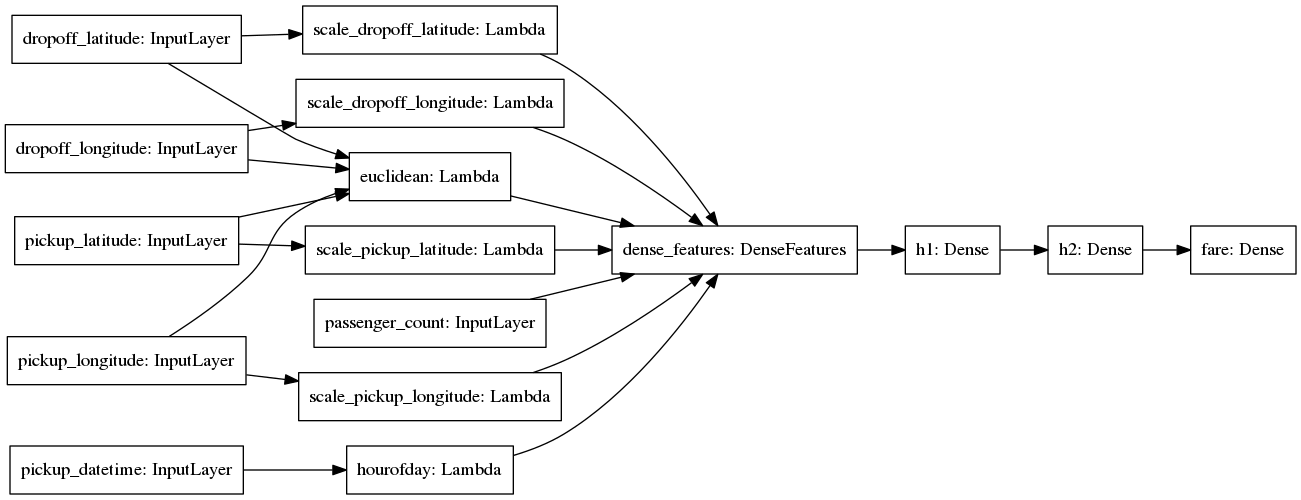

In [9]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Train model

To train the model, call model.fit()

In [12]:
trainds = load_dataset('taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//10000) # evaluate on 1/10 final evaluation set

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

shutil.rmtree('{}/checkpoints/'.format(OUTDIR), ignore_errors=True)
checkpoint_path = '{}/checkpoints/taxi'.format(OUTDIR)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch,
                    verbose=2, # 0=silent, 1=progress bar, 2=one line per epoch
                    callbacks=[cp_callback])

Repeating training dataset indefinitely
Train for 312 steps
Epoch 1/5

Epoch 00001: saving model to ./trained_model/checkpoints/taxi
312/312 - 6s - loss: 25.2922 - rmse: 4.3400 - mse: 25.2922 - val_loss: 26.1520 - val_rmse: 5.1139 - val_mse: 26.1520
Epoch 2/5

Epoch 00002: saving model to ./trained_model/checkpoints/taxi
312/1 - 5s - loss: 14.8204 - rmse: 4.0530 - mse: 23.6239 - val_loss: 24.5960 - val_rmse: 4.9594 - val_mse: 24.5960
Epoch 3/5

Epoch 00003: saving model to ./trained_model/checkpoints/taxi
312/1 - 5s - loss: 17.2018 - rmse: 4.0503 - mse: 27.8177 - val_loss: 23.6382 - val_rmse: 4.8619 - val_mse: 23.6382
Epoch 4/5

Epoch 00004: saving model to ./trained_model/checkpoints/taxi
312/1 - 5s - loss: 14.6912 - rmse: 3.9152 - mse: 21.2153 - val_loss: 25.3233 - val_rmse: 5.0322 - val_mse: 25.3233
Epoch 5/5

Epoch 00005: saving model to ./trained_model/checkpoints/taxi
312/1 - 5s - loss: 17.3619 - rmse: 3.9540 - mse: 25.8085 - val_loss: 22.8329 - val_rmse: 4.7784 - val_mse: 22.832

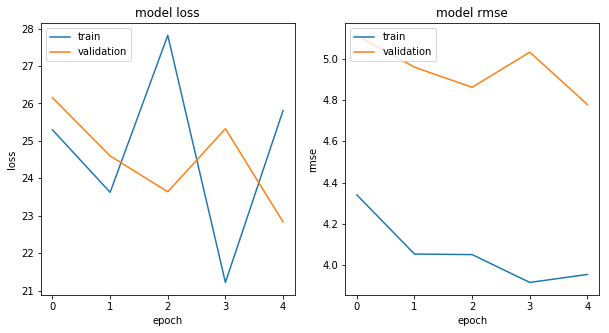

In [13]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Evaluate over full validation dataset

Let's evaluate over the full validation dataset (provided the validation dataset is large enough).

In [14]:
evalds = load_dataset('taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)
model.evaluate(evalds)

10/10 [==============================] - 0s 42ms/step - loss: 26.3426 - rmse: 5.1075 - mse: 26.3426


[26.342635345458984, 5.1075377, 26.342634]

Although we get $8.25 or so (your answer will be different due to random seeds), remember that we trained on a really small subset of the data. We need a larger training dataset before making decisions about this model.

## Predict with model

This is how to predict with this model:

In [15]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'pickup_datetime': tf.convert_to_tensor(['2010-02-08 09:17:00 UTC'], dtype=tf.string),
}, steps=1)

array([[7.3183208]], dtype=float32)

However, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect client code to instantiate the model from that exported file.

## Export model

Let's export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

In [16]:
import shutil, os, datetime
OUTPUT_DIR = os.path.join(OUTDIR, 'export/savedmodel')
if OUTPUT_DIR[:5] != 'gs://':
    shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH) # with default serving function

W0820 20:40:43.591048 140048220395264 deprecation.py:506] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}

The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_latitude:0
  inputs['dropoff_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_longitude:0
  inputs['passenger_count'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_passenger_count:0
  inputs['pickup_datetime'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_pickup_datetime:0
  inputs['pickup_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_pickup_latitude:0
  inputs['pickup_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_pickup_longitude:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['fare'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: Stateful

In [18]:
!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

./trained_model/export/savedmodel/20190820204041
./trained_model/export/savedmodel/20190820204041/saved_model.pb
./trained_model/export/savedmodel/20190820204041/assets
./trained_model/export/savedmodel/20190820204041/variables
./trained_model/export/savedmodel/20190820204041/variables/variables.index
./trained_model/export/savedmodel/20190820204041/variables/variables.data-00000-of-00001


In [20]:
%%bash
PROJECT=$(gcloud config get-value project)
BUCKET=${PROJECT}-ml
REGION=us-east1
MODEL_NAME=taxifare
VERSION_NAME=v2

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    # create model
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 10
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow --python-version=3.5 --runtime-version=1.14 \
       --origin=$EXPORT_PATH --staging-bucket=gs://$BUCKET

taxifare already exists
Creating taxifare:v2


In this notebook, we have looked at how to implement a custom Keras model using feature columns.

In [21]:
%%writefile repro.json
{"pickup_longitude": -73.982683, "pickup_latitude": 40.742104, "dropoff_longitude": -73.983766, "dropoff_latitude": 40.755174, "passenger_count": 3.0, "pickup_datetime": "2010-02-08 09:17:00 UTC"}

Writing repro.json


In [22]:
!gcloud ai-platform predict --model taxifare --json-instances repro.json --version v2

FARE
[7.3183207511901855]


To take a quick anonymous survey, run:
  $ gcloud alpha survey



Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.